# Using XGBoost for TimeSeries Forecast: A Start-To-Finish Generic Demo
Data_Source: Kaggle-ExportSales.csv<br>

Content:<br>
1.How to use AWS S3 Bukcet for data storage<br>
2.Feature Engineering<br>
3.Train-Test-Split<br>
4.XGB Model<br>
5.Visualise Results<br>
6.Export Forecasted Result into S3 Bucket

In [ ]:
#Import necessary libraries
import boto3
import pandas as pd
import numpy as np  
import optuna
import seaborn as sns
from io import StringIO
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sagemaker.session import s3_input, Session
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
#Import Data from S3 Bucket
bucket_name = 'xgb.regression.ml.pipeline' 
my_region = boto3.session.Session().region_name 
print(f'Region name: {my_region}')
path = 's3://xgb.regression.ml.pipeline/ExportSales.csv'
data = pd.read_csv(path)
data.head(5)

Region name: eu-west-2


,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.8225
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.8240
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.9520
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.8170
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.4460


In [404]:
Data = data[['Date','QTY']].sort_values(by = ['Date']).reset_index(drop =True)
DATA = Data.groupby(['Date'])['QTY'].sum().reset_index()

print(DATA.head())
print("Shape of the DataFrame:", DATA.shape)
print("Number of unique dates:", len(DATA['Date'].unique()))
DATA['Date'] = pd.to_datetime(DATA['Date'])

# Group by 'Date' and sum the 'QTY' column
DATA = DATA.groupby('Date')['QTY'].sum().reset_index()

DATA['Date'] = DATA.index

DATA.head()


         Date   QTY
0  2019-04-07   455
1  2019-04-10  2100
2  2019-04-18  1700
3  2019-04-28  7450
4  2019-04-29  4550
Shape of the DataFrame: (341, 2)
Number of unique dates: 341


,Date,QTY
0,0,455
1,1,2100
2,2,1700
3,3,7450
4,4,4550


# Let's have a look at the trend

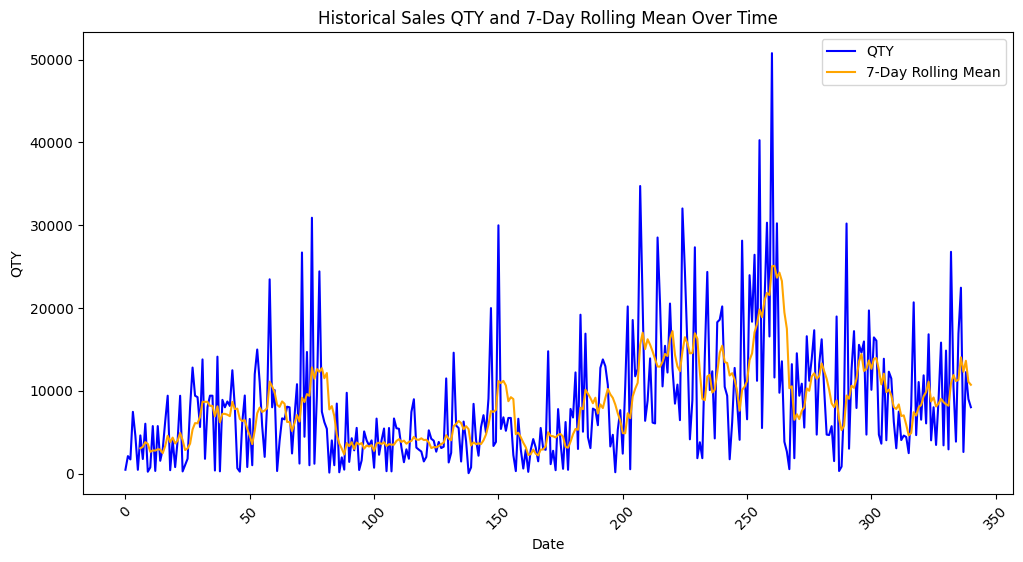

In [405]:

DATA['Rolling_Mean_7'] = DATA['QTY'].rolling(window=7).mean()

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(DATA['Date'],DATA['QTY'],color = 'blue',label='QTY')
plt.plot(DATA['Date'], DATA['Rolling_Mean_7'], color='orange', label='7-Day Rolling Mean')

plt.xlabel('Date')
plt.ylabel('QTY')
plt.title('Historical Sales QTY and 7-Day Rolling Mean Over Time')

plt.xticks(rotation=45)

plt.legend()
plt.show()

In [406]:
#Create lag features
DATA['Lag_1'] = DATA['QTY'].shift(1) 
DATA['Lag_7'] = DATA['QTY'].shift(7)
DATA['Lag_14'] = DATA['QTY'].shift(14)
DATA['Lag_21'] = DATA['QTY'].shift(21)
DATA['Lag_30'] = DATA['QTY'].shift(30)

   #Besides, let's add rolling statistics features
DATA['Rolling_Mean_7'] = DATA['QTY'].rolling(window=7).mean()
DATA['Rolling_Mean_21'] = DATA['QTY'].rolling(window=21).mean()
DATA['Rolling_Mean_30'] = DATA['QTY'].rolling(window=30).mean()
DATA['Rolling_Mean_60'] = DATA['QTY'].rolling(window=60).mean()
DATA['Rolling_Mean_90'] = DATA['QTY'].rolling(window=90).mean()

DATA['Rolling_2_std'] = DATA['QTY'].rolling(window=2).std()
DATA['Rolling_3_std'] = DATA['QTY'].rolling(window=3).std()
DATA['Rolling_4_std'] = DATA['QTY'].rolling(window=4).std()
DATA['Rolling_7_std'] = DATA['QTY'].rolling(window=7).std()
DATA['Rolling_21_std'] = DATA['QTY'].rolling(window=21).std()
DATA['Rolling_30_std'] = DATA['QTY'].rolling(window=30).std()



In [407]:
DATA.iloc[88:,:]

,Date,QTY,Rolling_Mean_7,Lag_1,Lag_7,Lag_14,Lag_21,Lag_30,Rolling_Mean_21,Rolling_Mean_30,Rolling_Mean_60,Rolling_Mean_90,Rolling_2_std,Rolling_3_std,Rolling_4_std,Rolling_7_std,Rolling_21_std,Rolling_30_std
88,88,468,2303.857143,1950.0,5400.0,1000.0,2420.0,23460.0,7944.238095,7361.566667,7492.216667,NaN,1047.932250,960.681008,3877.174358,3036.008917,9072.843633,7766.647161
89,89,9752,3681.428571,468.0,109.0,30900.0,6910.0,8000.0,8079.571429,7419.966667,7501.083333,6367.800000,6564.779357,4987.654492,4516.633259,3930.174163,9077.839966,7778.191646
90,90,1400,3310.000000,9752.0,4000.0,1180.0,10790.0,10080.0,7632.428571,7130.633333,7430.750000,6378.300000,5905.755836,5112.357317,4283.565610,4016.950087,9168.465382,7837.048400
91,91,4260,3775.714286,1400.0,1000.0,9400.0,1200.0,300.0,7778.142857,7262.633333,7272.016667,6402.300000,2022.325394,4244.556671,4178.697086,3891.518543,9085.060266,7750.908211
92,92,2800,2968.571429,4260.0,8450.0,24420.0,26700.0,3942.0,6640.047619,7224.566667,7289.116667,6414.522222,1032.375901,1430.104891,3657.406549,3301.671640,8032.157721,7770.558457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,336,22446,14037.571429,16899.0,3400.0,6052.0,2460.0,4020.0,10840.190476,9456.400000,10007.266667,11825.355556,3922.321315,9546.874061,8032.573493,8961.649306,6955.099572,6439.572762
337,337,2600,12287.571429,22446.0,14850.0,16818.0,8190.0,12300.0,10574.000000,9133.066667,9762.100000,11809.022222,14033.241179,10239.582723,9775.583712,9921.252019,7165.394009,6534.689001
338,338,12243,13620.142857,2600.0,2915.0,4007.0,20678.0,11476.0,10172.333333,9158.633333,9887.816667,11632.488889,6818.630691,9924.316719,8405.659403,9039.857252,6797.661777,6545.662920
339,339,9000,11079.714286,12243.0,26783.0,8000.0,4637.0,6250.0,10380.095238,9250.300000,9817.900000,11599.711111,2293.147291,4906.874396,8282.634137,6990.738938,6685.776312,6522.740915


In [408]:
DATA= DATA.iloc[89:,:].reset_index(drop=True)
DATA['Date'] = DATA.index

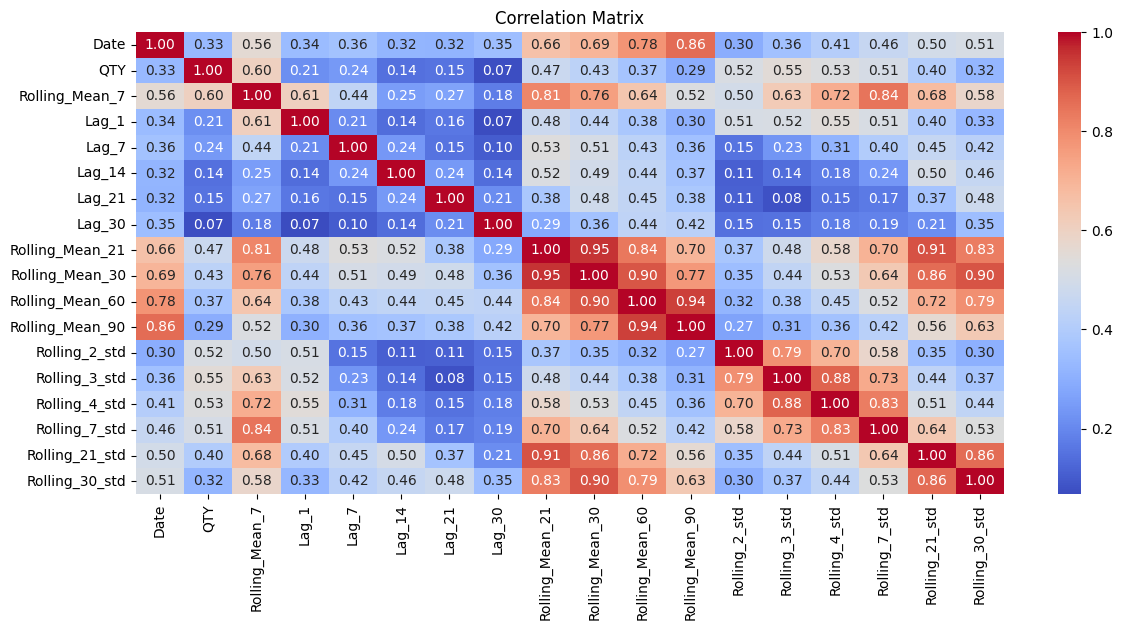

In [ ]:
#Explore Feature Importance for Feature Selection
correlation_matrix = DATA.corr()
plt.figure(figsize=(14, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [410]:
df = DATA
display(df.tail(),
df.shape,
df.isnull().sum())

,Date,QTY,Rolling_Mean_7,Lag_1,Lag_7,Lag_14,Lag_21,Lag_30,Rolling_Mean_21,Rolling_Mean_30,Rolling_Mean_60,Rolling_Mean_90,Rolling_2_std,Rolling_3_std,Rolling_4_std,Rolling_7_std,Rolling_21_std,Rolling_30_std
247,247,22446,14037.571429,16899.0,3400.0,6052.0,2460.0,4020.0,10840.190476,9456.400000,10007.266667,11825.355556,3922.321315,9546.874061,8032.573493,8961.649306,6955.099572,6439.572762
248,248,2600,12287.571429,22446.0,14850.0,16818.0,8190.0,12300.0,10574.000000,9133.066667,9762.100000,11809.022222,14033.241179,10239.582723,9775.583712,9921.252019,7165.394009,6534.689001
249,249,12243,13620.142857,2600.0,2915.0,4007.0,20678.0,11476.0,10172.333333,9158.633333,9887.816667,11632.488889,6818.630691,9924.316719,8405.659403,9039.857252,6797.661777,6545.662920
250,250,9000,11079.714286,12243.0,26783.0,8000.0,4637.0,6250.0,10380.095238,9250.300000,9817.900000,11599.711111,2293.147291,4906.874396,8282.634137,6990.738938,6685.776312,6522.740915
251,251,8008,10720.857143,9000.0,10520.0,3450.0,11050.0,3050.0,10235.238095,9415.566667,9681.133333,11615.911111,701.449927,2214.961926,4006.559736,7088.056678,6703.467408,6422.263323


(252, 18)

Date               0
QTY                0
Rolling_Mean_7     0
Lag_1              0
Lag_7              0
Lag_14             0
Lag_21             0
Lag_30             0
Rolling_Mean_21    0
Rolling_Mean_30    0
Rolling_Mean_60    0
Rolling_Mean_90    0
Rolling_2_std      0
Rolling_3_std      0
Rolling_4_std      0
Rolling_7_std      0
Rolling_21_std     0
Rolling_30_std     0
dtype: int64

# Train-Test-Split
As I want to do a 30 days short-term forecast, I will use the last 30 days to test and the rest to train model

In [411]:
df.columns

Index(['Date', 'QTY', 'Rolling_Mean_7', 'Lag_1', 'Lag_7', 'Lag_14', 'Lag_21',
       'Lag_30', 'Rolling_Mean_21', 'Rolling_Mean_30', 'Rolling_Mean_60',
       'Rolling_Mean_90', 'Rolling_2_std', 'Rolling_3_std', 'Rolling_4_std',
       'Rolling_7_std', 'Rolling_21_std', 'Rolling_30_std'],
      dtype='object')

In [412]:
features = ['Date','Rolling_Mean_7', 'Lag_1', 'Lag_7', 'Lag_14', 'Lag_21',
       'Lag_30', 'Rolling_Mean_21', 'Rolling_Mean_30', 'Rolling_Mean_60',
       'Rolling_Mean_90', 'Rolling_2_std', 'Rolling_3_std', 'Rolling_4_std',
       'Rolling_7_std', 'Rolling_21_std', 'Rolling_30_std']

target = ['QTY']

X_train = df.iloc[:-30][features]
y_train = df.iloc[:-30][target]
X_test = df.iloc[-30:][features]
y_test = df.iloc[-30:][target]

In [ ]:

# Initialize MinMaxScaler and fit-transform the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)  
X_test_scaled = scaler_X.transform(X_test)      

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Train XGB Model
Let's now train the model using the lag features as inputs

In [ ]:

#Initialise the model
model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, learning_rate=0.1)

#Fit the model
model.fit(X_train_scaled, y_train_scaled.ravel())


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Make predictions
use the trained model to predict sales for the next 30 days, using last 30 days' data

In [415]:
df.tail()

,Date,QTY,Rolling_Mean_7,Lag_1,Lag_7,Lag_14,Lag_21,Lag_30,Rolling_Mean_21,Rolling_Mean_30,Rolling_Mean_60,Rolling_Mean_90,Rolling_2_std,Rolling_3_std,Rolling_4_std,Rolling_7_std,Rolling_21_std,Rolling_30_std
247,247,22446,14037.571429,16899.0,3400.0,6052.0,2460.0,4020.0,10840.190476,9456.400000,10007.266667,11825.355556,3922.321315,9546.874061,8032.573493,8961.649306,6955.099572,6439.572762
248,248,2600,12287.571429,22446.0,14850.0,16818.0,8190.0,12300.0,10574.000000,9133.066667,9762.100000,11809.022222,14033.241179,10239.582723,9775.583712,9921.252019,7165.394009,6534.689001
249,249,12243,13620.142857,2600.0,2915.0,4007.0,20678.0,11476.0,10172.333333,9158.633333,9887.816667,11632.488889,6818.630691,9924.316719,8405.659403,9039.857252,6797.661777,6545.662920
250,250,9000,11079.714286,12243.0,26783.0,8000.0,4637.0,6250.0,10380.095238,9250.300000,9817.900000,11599.711111,2293.147291,4906.874396,8282.634137,6990.738938,6685.776312,6522.740915
251,251,8008,10720.857143,9000.0,10520.0,3450.0,11050.0,3050.0,10235.238095,9415.566667,9681.133333,11615.911111,701.449927,2214.961926,4006.559736,7088.056678,6703.467408,6422.263323


In [ ]:
y_pred_scaled = model.predict(X_test_scaled)

# Reverse the scaling (if you need the original scale)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

last_Date = df['Date'].iloc[-1]

# Create a DataFrame for future predictions
y_pred_df = pd.DataFrame({'Date': '', 'y_pred': y_pred.flatten()})

# Set the first predicted date to be one day after the last date
y_pred_df.loc[0, 'Date'] = last_Date + 1

for i in range(1, 30):  # Start from 1, as the first date is already set
    y_pred_df.loc[i, 'Date'] = y_pred_df.loc[i-1, 'Date'] + 1
    y_pred_df.loc[i, 'y_pred'] = y_pred[i, 0]

y_pred_df['y_pred'] = y_pred_df['y_pred'].astype(int)
y_pred_df.head()


,Date,y_pred
0,252,4676
1,253,4693
2,254,4637
3,255,6673
4,256,4016


In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = (np.abs((y_test.values.flatten() - y_pred.flatten()) / y_test.values.flatten()) * 100).mean()

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 2894.1835
Root Mean Squared Error (RMSE): 3707.3236
Mean Absolute Percentage Error (MAPE): 44.06%


/Users/wayne/Desktop/Machine_Learning/Kaggle/ML_Projects/XGB-Regre-SM-Pipeline/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Forecast Accuracy (1-MAPE): 55.94%


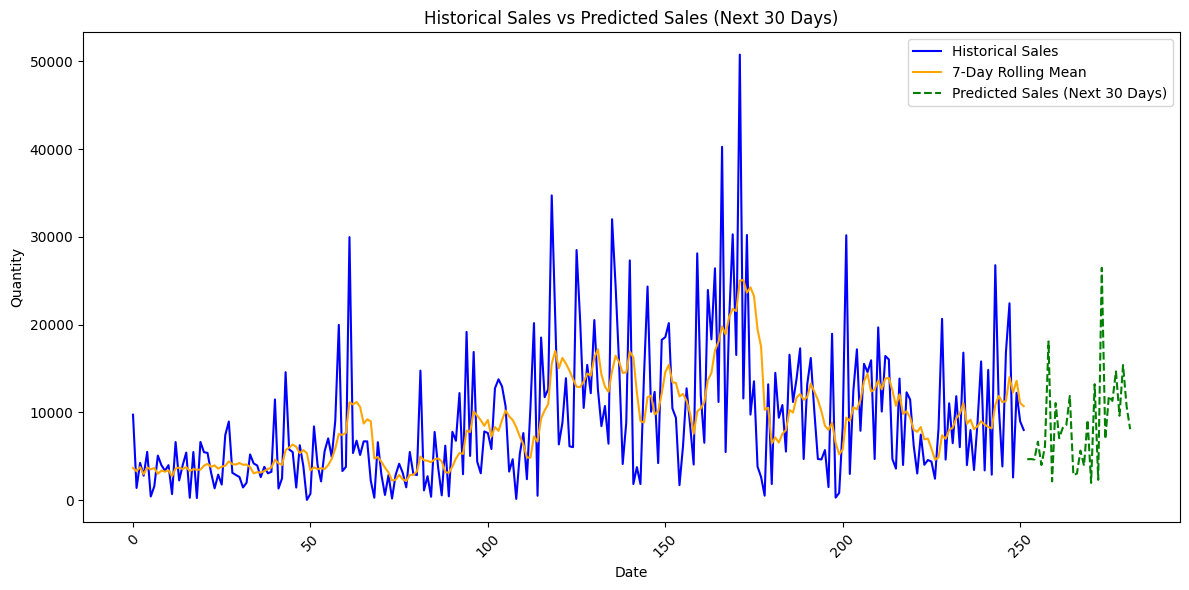

In [ ]:
print(f"Forecast Accuracy (1-MAPE): {100 - mape:.2f}%")

# Create a DataFrame for historical data with 'Date' and 'QTY' columns
historical_data = df[['Date', 'QTY']]

# Create a DataFrame for the predictions with corresponding dates from X_test
last_date = df['Date'].iloc[-1] 

# Combine historical data and predicted data for plotting
combined_data = pd.concat([historical_data, y_pred_df], ignore_index=True)

# Plotting historical sales and predictions
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(historical_data['Date'], historical_data['QTY'], label='Historical Sales', color='blue')
plt.plot(DATA['Date'], DATA['Rolling_Mean_7'], color='orange', label='7-Day Rolling Mean')
# Plot predicted data (next 30 days)
plt.plot(y_pred_df['Date'], y_pred_df['y_pred'], label='Predicted Sales (Next 30 Days)', color='green', linestyle='--')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Historical Sales vs Predicted Sales (Next 30 Days)')

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Upload result into AWS S3

In [ ]:

# Assuming df is your DataFrame to be uploaded
df = y_pred_df  # Assuming y_pred_df is the DataFrame to be uploaded

bucket_name = 'xgb.regression.ml.pipeline'

# Specify the S3 bucket name and the file name/path in the bucket
file_name = 'forecast_result.csv'  # Replace this with the desired file path in S3

# Convert DataFrame to CSV format in memory
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)

# Initialize a session using your AWS credentials
s3 = boto3.client('s3')

# Upload the CSV to S3
s3.put_object(Bucket=bucket_name, Key=file_name, Body=csv_buffer.getvalue())

# Confirm the upload
print(f"File successfully uploaded to s3://{bucket_name}/{file_name}")


File successfully uploaded to s3://xgb.regression.ml.pipeline/forecast_result.csv
